In [1]:
import gensim
import logging
import numpy as np
from nltk.corpus import stopwords

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
model = gensim.models.KeyedVectors.load_word2vec_format('../data/GoogleNews-vectors-negative300.bin.gz', binary=True)

2017-03-29 00:48:56,962 : INFO : loading projection weights from ../data/GoogleNews-vectors-negative300.bin.gz
2017-03-29 00:51:28,565 : INFO : loaded (3000000, 300) matrix from ../data/GoogleNews-vectors-negative300.bin.gz


In [4]:
model.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.7118192315101624),
 ('monarch', 0.6189675331115723),
 ('princess', 0.5902431607246399),
 ('crown_prince', 0.549946129322052),
 ('prince', 0.5377321839332581),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098592638969421),
 ('monarchy', 0.5087412595748901)]

In [13]:
king = model['king']
queen = model['queen']

In [170]:
model.similarity('japanese', 'otaku')

0.48780448994391717

In [131]:
from numpy import linalg as LA

In [146]:
LA.norm(model['king'] - model['queen'])

2.4796925

In [153]:
LA.norm(model['king'] - model['queen'])

2.4796925

In [155]:
np.dot(model['king'], model['queen'])

5.7224302

In [160]:
np.dot(model['king'], model['otaku']) / LA.norm(model['king']) / LA.norm(model['otaku'])

0.12480784

In [165]:
LA.norm(model['japan'] - model['otaku'])

4.3429632

In [174]:
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.optimize import minimize
stops = set(stopwords.words("english"))
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import multiprocessing
import difflib

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 1))
#cvect = CountVectorizer(stop_words='english', ngram_range=(1, 1))

tfidf_txt = ['unko', 'yjsnpi']
tfidf.fit_transform(tfidf_txt)

<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [187]:
feature_names = tfidf.get_feature_names()
tfidf_index = {word: i for i, word in enumerate(feature_names)}
tfidf_index

{'unko': 0, 'yjsnpi': 1}

In [231]:
train = pd.read_csv('../input/train.csv')[:1000]
test = pd.read_csv('../input/test.csv')[:1000]

In [200]:
train[train['is_duplicate'] == 1]

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1
15,15,31,32,What would a Trump presidency mean for current...,How will a Trump presidency affect the student...,1
16,16,33,34,What does manipulation mean?,What does manipulation means?,1
18,18,37,38,Why are so many Quora users posting questions ...,Why do people ask Quora questions which can be...,1
20,20,41,42,Why do rockets look white?,Why are rockets and boosters painted white?,1
29,29,59,60,How should I prepare for CA final law?,How one should know that he/she completely pre...,1


In [232]:
import nltk

stops = stopwords.words()
def filter_stopwords(s):
    return [w for w in s.lower().split() if w not in stops]
def filter_stopwords_tok(s):
    return [w for w in nltk.word_tokenize(s.lower()) if w not in stops]
train['q1_words'] = train.question1.apply(filter_stopwords)
train['q1_tok_words'] = train.question1.apply(filter_stopwords_tok)

train['q2_words'] = train.question2.apply(filter_stopwords)
train['q2_tok_words'] = train.question2.apply(filter_stopwords_tok)

In [235]:
def n_sim(row):
    w1 = [w for w in row['q1_tok_words'] if w in model]
    w2 = [w for w in row['q2_tok_words'] if w in model]
    if w1 and w2:
        return model.n_similarity(w1, w2)
    else:
        return 0

train['n_sim'] = train.apply(n_sim, axis=1)

,id,qid1,qid2,question1,question2,is_duplicate,q1_words,q1_tok_words,q2_words,q2_tok_words,n_sim
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, ind...","[step, step, guide, invest, share, market, ind...","[step, step, guide, invest, share, market?]","[step, step, guide, invest, share, market, ?]",0.931028
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, (koh-i-noor), diamond?]","[story, kohinoor, (, koh-i-noor, ), diamond, ?]","[would, happen, indian, government, stole, koh...","[would, happen, indian, government, stole, koh...",0.487836
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns?]","[internet, speed, increased, hacking, dns, ?]",0.777991
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely?, solve, it?]","[mentally, lonely, ?, solve, ?]","[find, remainder, [math]23^{24}[/math], divide...","[find, remainder, [, math, ], 23^, {, 24, }, [...",0.349589
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar,, salt,, ...","[one, dissolve, water, quikly, sugar, ,, salt,...","[fish, would, survive, salt, water?]","[fish, would, survive, salt, water, ?]",0.646916
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,"[astrology:, capricorn, sun, cap, moon, cap, r...","[astrology, :, capricorn, sun, cap, moon, cap,...","[i'm, triple, capricorn, (sun,, moon, ascendan...","['m, triple, capricorn, (, sun, ,, moon, ascen...",0.709208
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,"[buy, tiago?]","[buy, tiago, ?]","[keeps, childern, active, far, phone, video, g...","[keeps, childern, active, far, phone, video, g...",0.179363
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,"[good, geologist?]","[good, geologist, ?]","[great, geologist?]","[great, geologist, ?]",0.935385
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,"[use, シ, instead, し?]","[use, シ, instead, し, ?]","[use, ""&"", instead, ""and""?]","[use, ``, &, '', instead, ``, '', ?]",0.831673
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,"[motorola, (company):, hack, charter, motoroll...","[motorola, (, company, ), :, hack, charter, mo...","[hack, motorola, dcx3400, free, internet?]","[hack, motorola, dcx3400, free, internet, ?]",0.715290


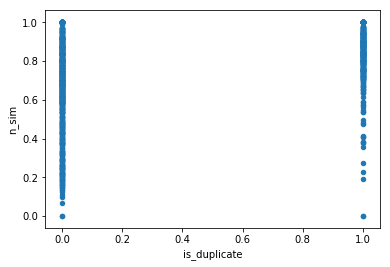

In [234]:
import matplotlib.pyplot as plt

train.plot(kind='scatter', x='is_duplicate', y='n_sim')

plt.show()